In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers
!pip install -q datasets jiwer
!pip install paddlepaddle paddleocr
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd

df = pd.read_fwf('/content/drive/MyDrive/captcha/gt_test.txt', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df

,file_name,text
0,00V9V.jpg,00V9V
1,01540.jpg,01540
2,02TFN.jpg,02TFN
3,02VV9.jpg,02VV9
4,046SV.jpg,046SV
...,...,...
1046,ZR2MG.jpg,ZR2MG
1047,ZS7R3.jpg,ZS7R3
1048,ZS82J.jpg,ZS82J
1049,ZUK2J.jpg,ZUK2J


In [4]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch
import numpy as np
import cv2
from torchvision import transforms
from transformers import AdamW
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datasets import load_metric
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix
from datasets import load_metric
import seaborn as sns
from PIL import Image
import numpy as np
from paddleocr import PaddleOCR
import os

In [5]:
# Initial split into training and test datasets
train_df, test_df = train_test_split(df, test_size=0.1)

# Further split the training dataset into training and validation datasets
train_df, valid_df = train_test_split(train_df, test_size=0.2)

# Reset indices to start from zero
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [6]:
def preprocess_image(image):
    """Applies connected component filtering to retain only the largest 5 components."""
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding to enhance the contrast between characters and background
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=8)

    # Create an output image to retain only the largest 5 components
    output_image = np.zeros_like(thresh)

    # Sort components by size (stat array is [x, y, width, height, area])
    areas = stats[:, cv2.CC_STAT_AREA]
    largest_indices = np.argsort(areas)[::-1][:6]  # Get indices of the 5 largest components + 1 for background

    for i in largest_indices:
        if i == 0:
            continue  # Skip the background component
        output_image[labels == i] = 255

    mask = output_image

    # Invert the mask
    inverted_mask = cv2.bitwise_not(mask)

    # Convert the single-channel mask to 3 channels
    inverted_mask = cv2.cvtColor(inverted_mask, cv2.COLOR_GRAY2BGR)


    result_image=cv2.bitwise_or(image, inverted_mask)

    return result_image

In [7]:
# Preprocess all images before using DataLoader
def preprocess_all_images(df, input_dir, output_dir):
    """Preprocess images from the input directory and save them to the output directory."""
    for i, file_name in enumerate(df['file_name']):
        image_path = input_dir + file_name
        image = cv2.imread(image_path)
        processed_image = preprocess_image(image)
        output_path = output_dir + file_name
        cv2.imwrite(output_path, processed_image)

In [8]:
# Define directories
input_dir = '/content/drive/MyDrive/captcha/image/'
processed_dir = '/content/drive/MyDrive/captcha/processed_images/'


In [ ]:
# Preprocess the images
preprocess_all_images(train_df, input_dir, processed_dir)
preprocess_all_images(valid_df, input_dir, processed_dir)
preprocess_all_images(test_df, input_dir, processed_dir)


NameError: name 'preprocess_all_images' is not defined

In [9]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]

        # Load the preprocessed image
        image_path = os.path.join(self.root_dir, file_name)
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            return None

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None

        # Convert image to tensor and process using the processor
        try:
            #image_tensor = transforms.ToTensor()(image)
            pixel_values = self.processor(image, return_tensors="pt").pixel_values
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None

        # Encode the text labels
        try:
            labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
            labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        except Exception as e:
            print(f"Error encoding text {text}: {e}")
            return None

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding


In [10]:
# Display the processed image before training
def show_processed_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Apply Median Filter
    processed_image_1= preprocess_image(image)

    # Plotting the original and processed images side by side
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Processed Image 1')
    plt.imshow(processed_image_1, cmap='gray')
    plt.axis('off')


    plt.show()

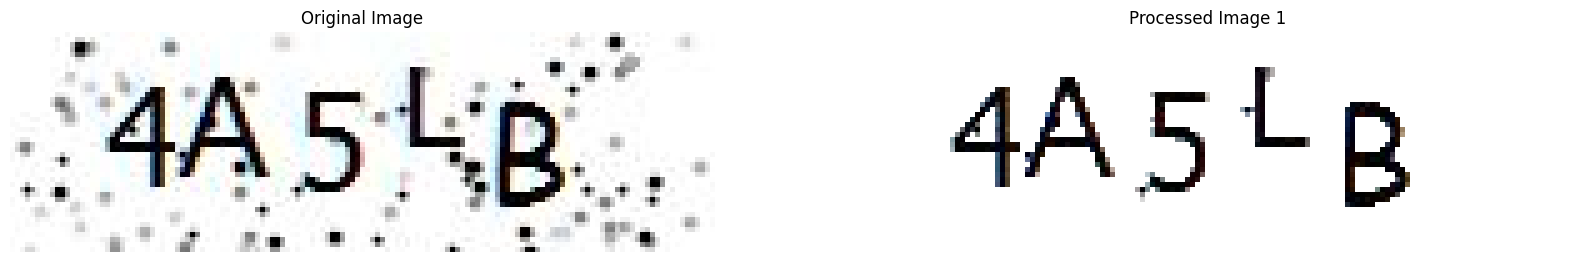

In [11]:
# Example usage with the first image in the dataset
example_image_path = '/content/drive/MyDrive/captcha/image/' + train_df['file_name'][5]
show_processed_image(example_image_path)

In [70]:
# Create datasets and dataloaders using the preprocessed image directory
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
train_dataset = IAMDataset(root_dir=processed_dir, df=train_df, processor=processor)
val_dataset = IAMDataset(root_dir=processed_dir, df=valid_df, processor=processor)
test_dataset = IAMDataset(root_dir=processed_dir, df=test_df, processor=processor)

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [58]:
print("Number of validation examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of validation examples:", len(test_dataset))

Number of validation examples: 756
Number of validation examples: 189
Number of validation examples: 106


In [59]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


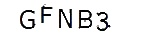

In [60]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [61]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

GFNB3


In [71]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [72]:
# Initialize your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')
model.to(device)

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [73]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 7
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 6

In [74]:
cer_metric = load_metric("cer")

In [75]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [76]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Variable to track the best CER
best_cer = float('inf')

# Training loop
for epoch in range(100):
    # Train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        for k, v in batch.items():
            batch[k] = v.to(device)
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    print(f"Loss after epoch {epoch}:", train_loss / len(train_dataloader))

    # Evaluate
    model.eval()
    valid_cer = 0.0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"]

            # Run batch generation
            outputs = model.generate(pixel_values)

            # Compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=labels)
            valid_cer += cer

    total_cer = valid_cer / len(val_dataloader)
    print("Validation CER:", total_cer)

    # Save model if the current CER is lower than the best CER
    if total_cer < best_cer and total_cer < 0.05:
        best_cer = total_cer
        print(f"New best CER: {best_cer}. Saving model...")
        import datetime
        save_pretrained_dir = f'drive/MyDrive/checkpoints/{total_cer}_{epoch}_{datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9),"JST")).strftime("%Y%m%dT%H%M%S")}'
        model.save_pretrained(save_pretrained_dir)

# Final model save
model.save_pretrained("/content/drive/MyDrive/model_final_2")


  0%|          | 0/95 [00:00<?, ?it/s]

Loss after epoch 0: 1.0639052475753583


  0%|          | 0/24 [00:00<?, ?it/s]

Validation CER: 0.09541666666666669


  0%|          | 0/95 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
# Load the metrics
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
model = VisionEncoderDecoderModel.from_pretrained("/content/model_final")
model.to(device)


# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # Adjust lang if needed


# Initialize lists and counters for your model
predictions_model = []
ground_truths = []
cer_scores_model = []
wer_scores_model = []
error_counter_model = Counter()
latencies_model = []

# Initialize lists and counters for PaddleOCR
predictions_paddle = []
cer_scores_paddle = []
wer_scores_paddle = []
latencies_paddle = []

all_true_chars = []
all_predicted_chars_model = []
all_predicted_chars_paddle = []


# Main loop over your dataset
for idx, (file_name, true_text) in enumerate(zip(df['file_name'], df['text'])):
    image_path = processed_dir + file_name
    image = Image.open(image_path).convert("RGB")

    # Test your custom model
    start_time = time.time()

    # Preprocess the image and move it to the same device as the model
    inputs = processor(images=image, return_tensors="pt").pixel_values.to(device)
    generated_ids = model.generate(inputs)

    end_time = time.time()

    latency_model = end_time - start_time
    latencies_model.append(latency_model)

    predicted_text_model = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    predictions_model.append(predicted_text_model)
    ground_truths.append(true_text)

    cer_score_model = cer_metric.compute(predictions=[predicted_text_model], references=[true_text])
    wer_score_model = wer_metric.compute(predictions=[predicted_text_model], references=[true_text])

    cer_scores_model.append(cer_score_model)
    wer_scores_model.append(wer_score_model)

    # Output the WER score, predicted text, and true text for each iteration
    print(f"Iteration {idx + 1}:")
    print(f"True Text: {true_text}")
    print(f"Predicted Text (Custom Model): {predicted_text_model}")
    print(f"WER Score (Custom Model): {wer_score_model:.4f}\n")

    for pred_char, true_char in zip(predicted_text_model, true_text):
        if pred_char != true_char:
            error_counter_model[true_char] += 1

        all_true_chars.append(true_char)
        all_predicted_chars_model.append(pred_char)

    # Test PaddleOCR
    start_time = time.time()
    ocr_result = ocr.ocr(image_path, cls=True)
    end_time = time.time()

    latency_paddle = end_time - start_time
    latencies_paddle.append(latency_paddle)

    # Extract text from PaddleOCR results
    if ocr_result and ocr_result[0] and ocr_result[0][0]:
        predicted_text_paddle = ''.join([res[1][0] for res in ocr_result[0]])
    else:
        predicted_text_paddle = ""

    predictions_paddle.append(predicted_text_paddle)

    cer_score_paddle = cer_metric.compute(predictions=[predicted_text_paddle], references=[true_text])
    wer_score_paddle = wer_metric.compute(predictions=[predicted_text_paddle], references=[true_text])

    cer_scores_paddle.append(cer_score_paddle)
    wer_scores_paddle.append(wer_score_paddle)

    # Output the WER score, predicted text, and true text for PaddleOCR
    print(f"True Text: {true_text}")
    print(f"Predicted Text (PaddleOCR): {predicted_text_paddle}")
    print(f"WER Score (PaddleOCR): {wer_score_paddle:.4f}\n")

    for pred_char, true_char in zip(predicted_text_paddle, true_text):
        all_predicted_chars_paddle.append(pred_char)


Streaming output truncated to the last 5000 lines.

[2024/09/02 20:07:02] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.013422966003417969
[2024/09/02 20:07:02] ppocr DEBUG: cls num  : 1, elapsed : 0.01212000846862793
[2024/09/02 20:07:02] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06084442138671875
True Text: K5S0I
Predicted Text (PaddleOCR): K5s OI
WER Score (PaddleOCR): 2.0000

Iteration 636:
True Text: K6US6
Predicted Text (Custom Model): K6US6
WER Score (Custom Model): 0.0000

[2024/09/02 20:07:03] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.014421224594116211
[2024/09/02 20:07:03] ppocr DEBUG: cls num  : 1, elapsed : 0.011648178100585938
[2024/09/02 20:07:03] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0529026985168457
True Text: K6US6
Predicted Text (PaddleOCR): K6 US6
WER Score (PaddleOCR): 2.0000

Iteration 637:
True Text: K7GRV
Predicted Text (Custom Model): K7GRV
WER Score (Custom Model): 0.0000

[2024/09/02 20:07:03] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.012016057968139648


In [44]:
# Calculate accuracy for both models
accuracy_model = accuracy_score(ground_truths, predictions_model)
accuracy_paddle = accuracy_score(ground_truths, predictions_paddle)

# Calculate average CER and WER for both models
avg_cer_model = sum(cer_scores_model) / len(cer_scores_model)
avg_wer_model = sum(wer_scores_model) / len(wer_scores_model)
avg_cer_paddle = sum(cer_scores_paddle) / len(cer_scores_paddle)
avg_wer_paddle = sum(wer_scores_paddle) / len(wer_scores_paddle)

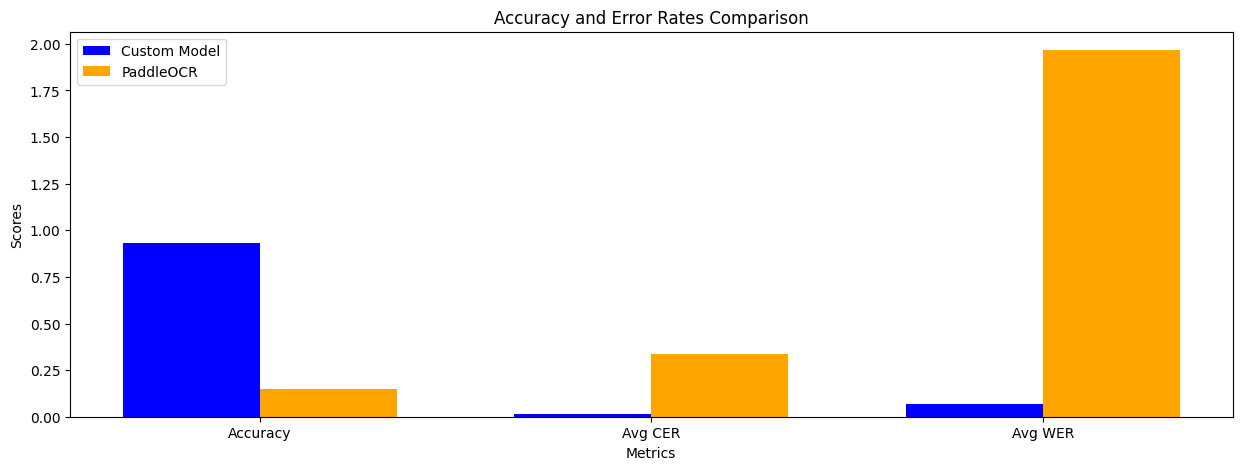

In [45]:
# Plot Accuracy, Average CER, and WER for both models
plt.figure(figsize=(15, 5))
metrics = ['Accuracy', 'Avg CER', 'Avg WER']
scores_model = [accuracy_model, avg_cer_model, avg_wer_model]
scores_paddle = [accuracy_paddle, avg_cer_paddle, avg_wer_paddle]

bar_width = 0.35
index = range(len(metrics))
plt.bar(index, scores_model, bar_width, label='Custom Model', color='blue')
plt.bar([i + bar_width for i in index], scores_paddle, bar_width, label='PaddleOCR', color='orange')

plt.title('Accuracy and Error Rates Comparison')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks([i + bar_width / 2 for i in index], metrics)
plt.legend()
plt.show()

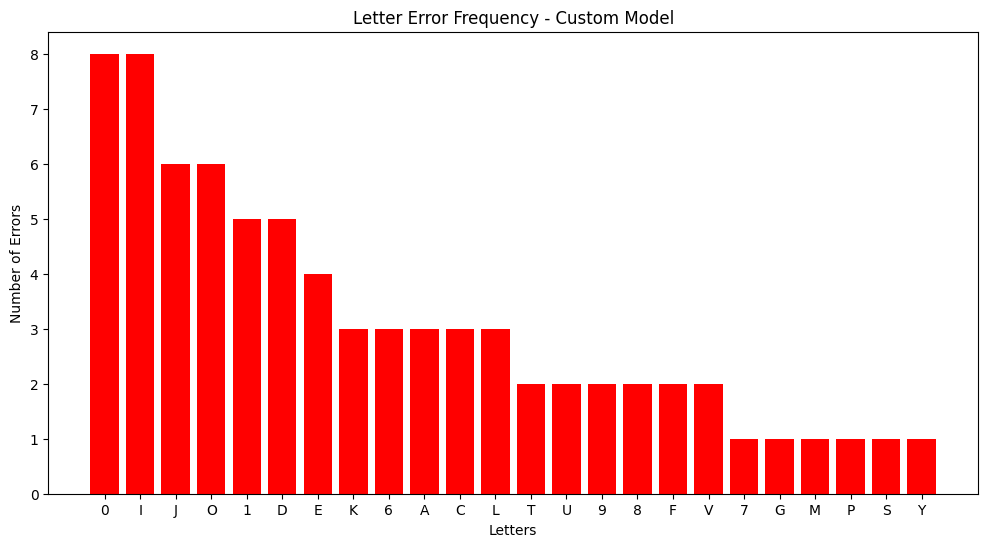

In [46]:
# Plot the most common letter errors for Custom Model
letters, counts = zip(*error_counter_model.most_common())
plt.figure(figsize=(12, 6))
plt.bar(letters, counts, color='red')
plt.title('Letter Error Frequency - Custom Model')
plt.xlabel('Letters')
plt.ylabel('Number of Errors')
plt.show()

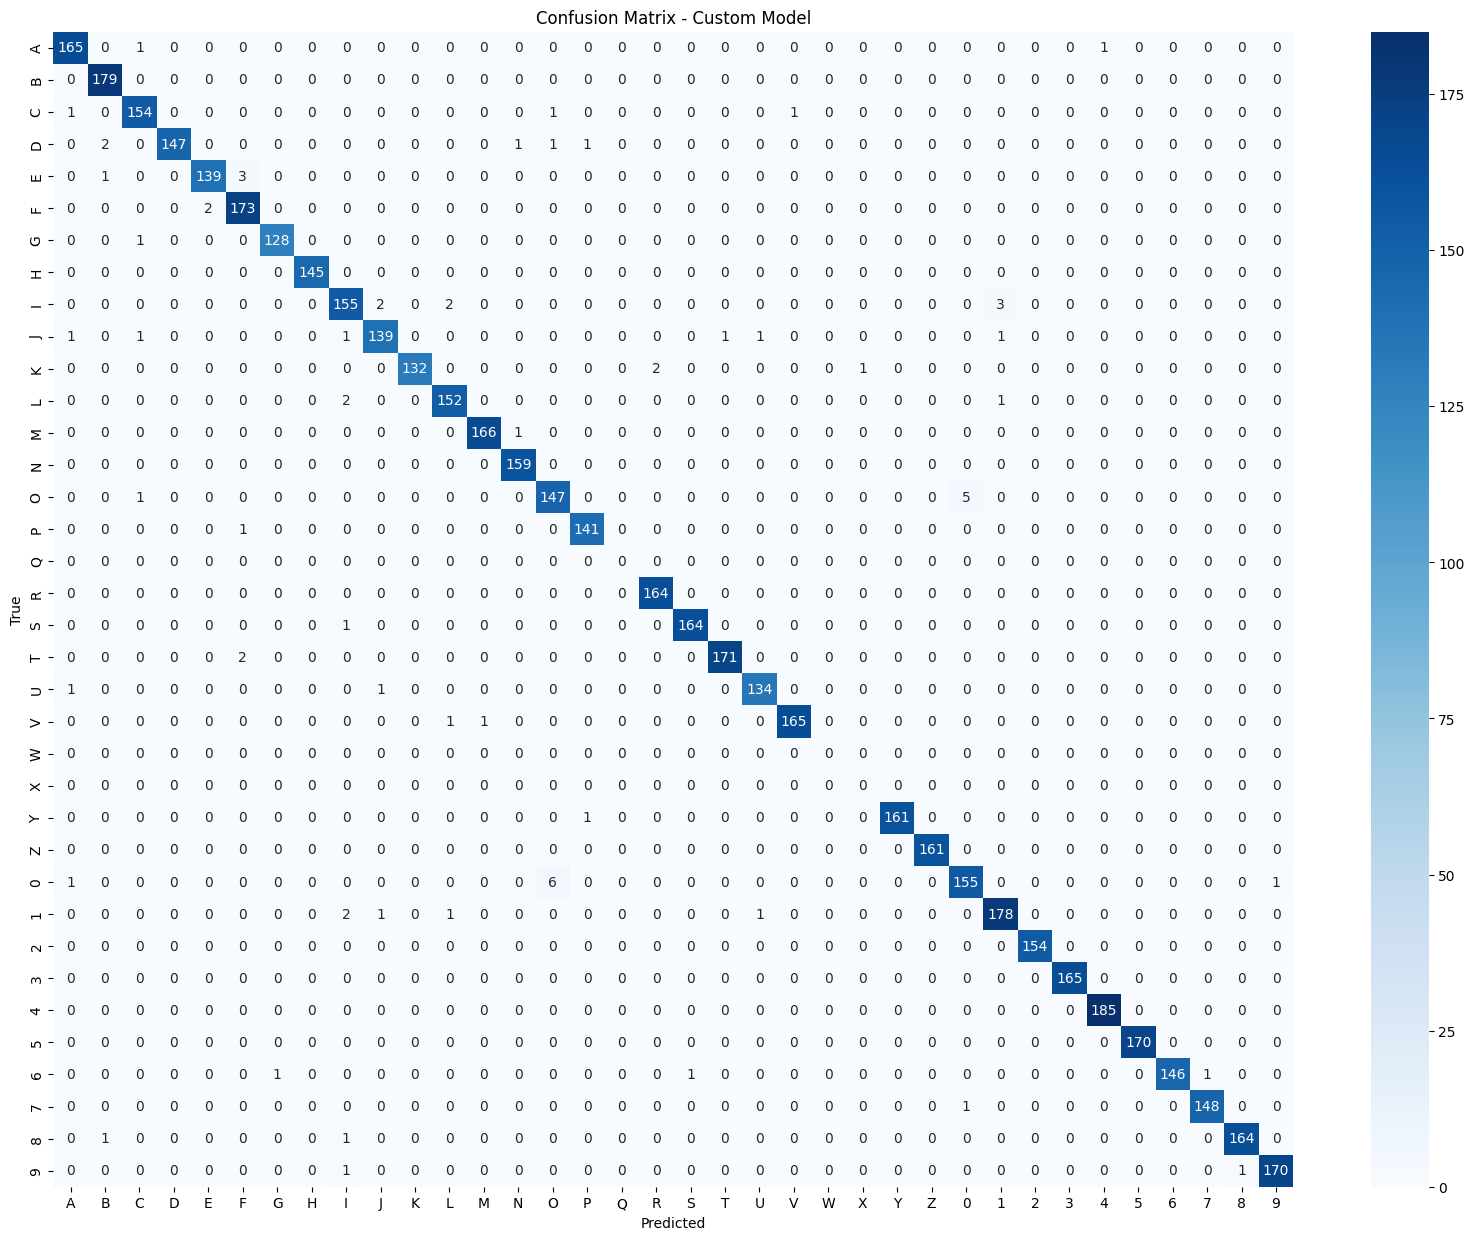

In [47]:
# Confusion Matrix for Custom Model
cm_model = confusion_matrix(all_true_chars, all_predicted_chars_model, labels=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"))
plt.figure(figsize=(20, 15))
sns.heatmap(cm_model, annot=True, fmt='d', cmap='Blues', xticklabels=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"), yticklabels=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"))
plt.title('Confusion Matrix - Custom Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

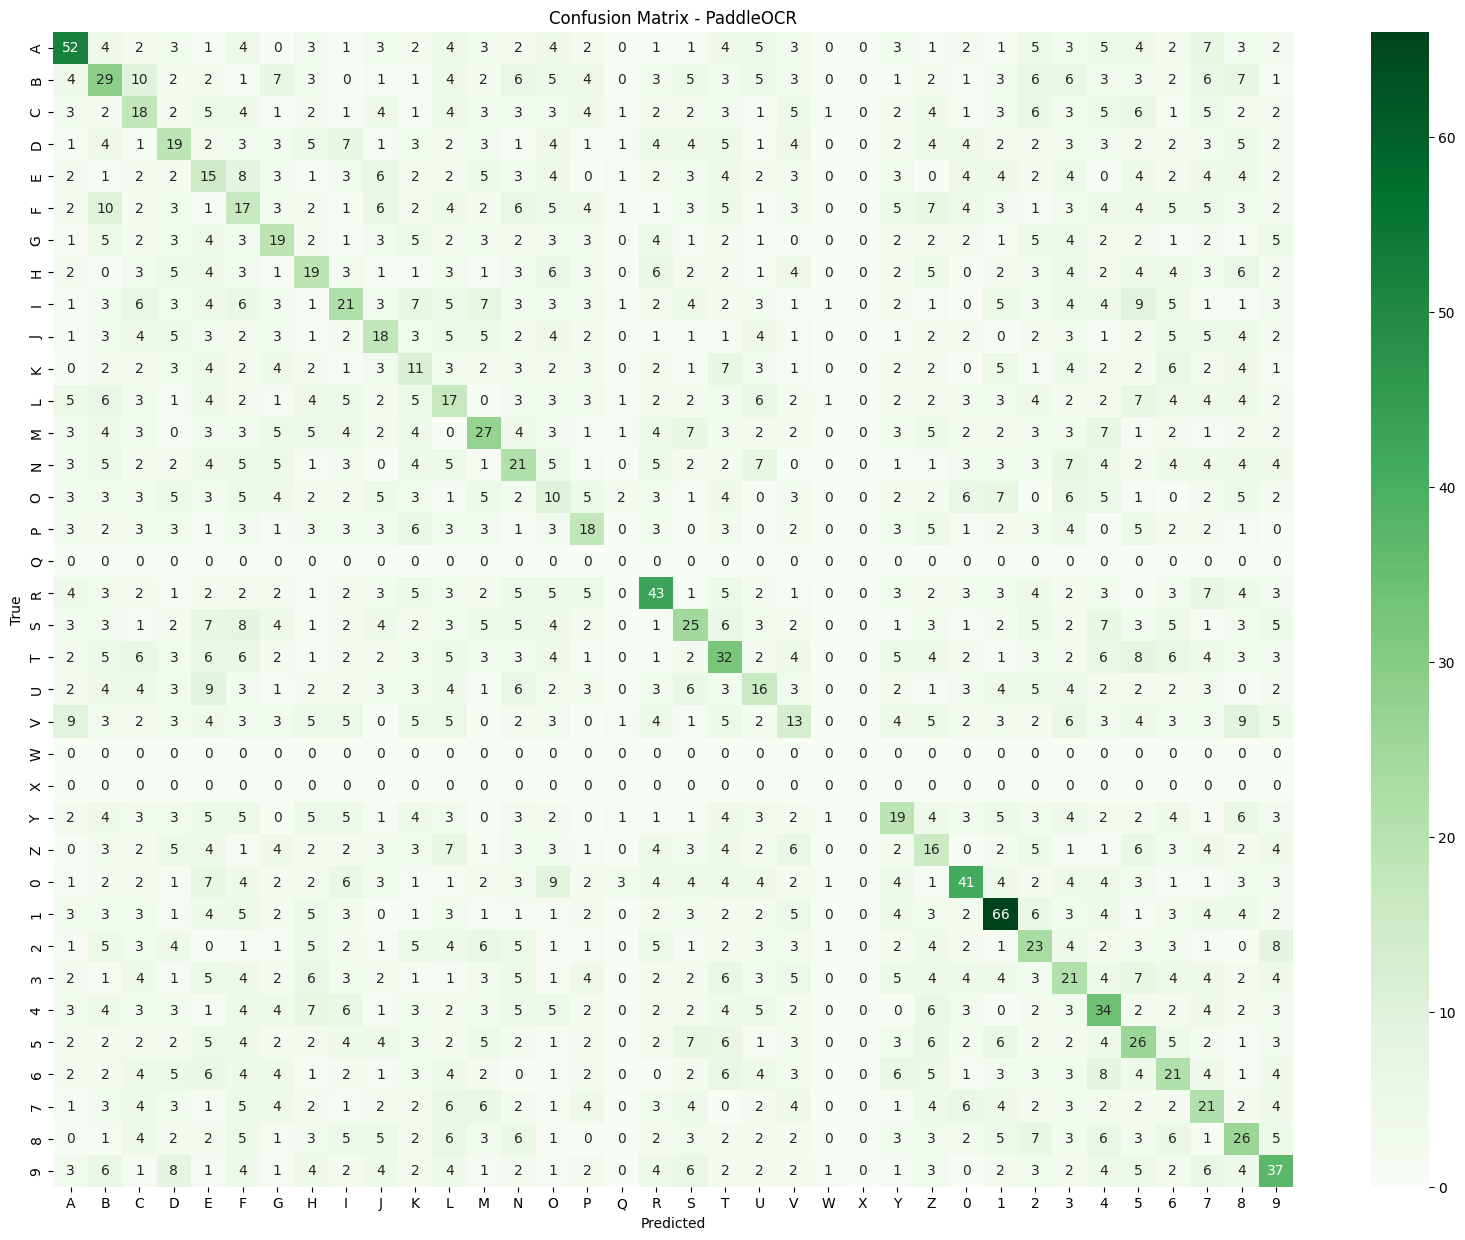

In [48]:
# Ensure lengths are the same by trimming to the shortest list
min_length = min(len(all_true_chars), len(all_predicted_chars_paddle))

# Trim both lists to the minimum length
all_true_chars_trimmed = all_true_chars[:min_length]
all_predicted_chars_paddle_trimmed = all_predicted_chars_paddle[:min_length]

# Confusion Matrix for PaddleOCR with trimmed lists
cm_paddle = confusion_matrix(all_true_chars_trimmed, all_predicted_chars_paddle_trimmed, labels=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"))
plt.figure(figsize=(20, 15))
sns.heatmap(cm_paddle, annot=True, fmt='d', cmap='Greens', xticklabels=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"), yticklabels=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"))
plt.title('Confusion Matrix - PaddleOCR')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


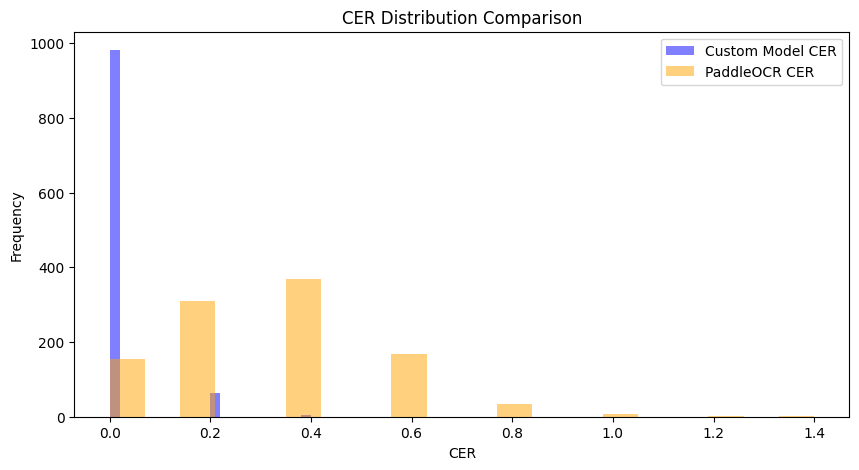

In [49]:
# CER Distribution Comparison
plt.figure(figsize=(10, 5))
plt.hist(cer_scores_model, bins=20, alpha=0.5, label='Custom Model CER', color='blue')
plt.hist(cer_scores_paddle, bins=20, alpha=0.5, label='PaddleOCR CER', color='orange')
plt.title('CER Distribution Comparison')
plt.xlabel('CER')
plt.ylabel('Frequency')
plt.legend()
plt.show()

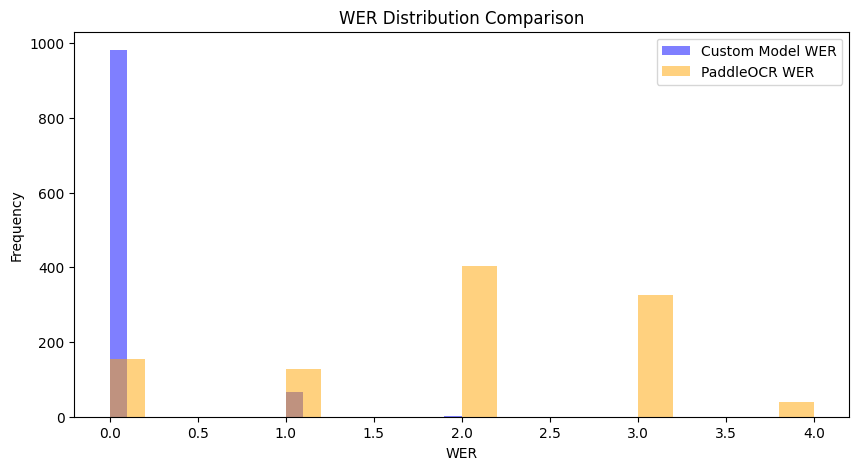

In [50]:
# WER Distribution Comparison
plt.figure(figsize=(10, 5))
plt.hist(wer_scores_model, bins=20, alpha=0.5, label='Custom Model WER', color='blue')
plt.hist(wer_scores_paddle, bins=20, alpha=0.5, label='PaddleOCR WER', color='orange')
plt.title('WER Distribution Comparison')
plt.xlabel('WER')
plt.ylabel('Frequency')
plt.legend()
plt.show()

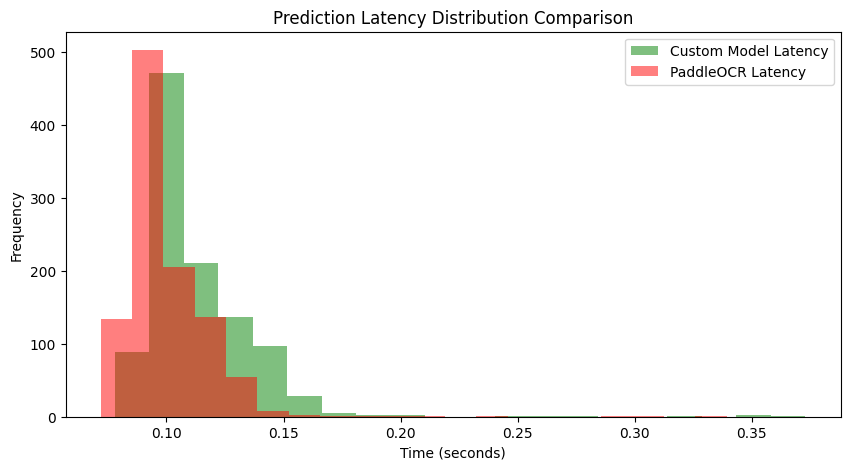

In [51]:
# Prediction Latency Distribution Comparison
plt.figure(figsize=(10, 5))
plt.hist(latencies_model, bins=20, alpha=0.5, label='Custom Model Latency', color='green')
plt.hist(latencies_paddle, bins=20, alpha=0.5, label='PaddleOCR Latency', color='red')
plt.title('Prediction Latency Distribution Comparison')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [52]:
print(f"Custom Model - Average Latency: {sum(latencies_model) / len(latencies_model):.4f} seconds")
print(f"PaddleOCR - Average Latency: {sum(latencies_paddle) / len(latencies_paddle):.4f} seconds")


Custom Model - Average Latency: 0.1146 seconds
PaddleOCR - Average Latency: 0.0996 seconds


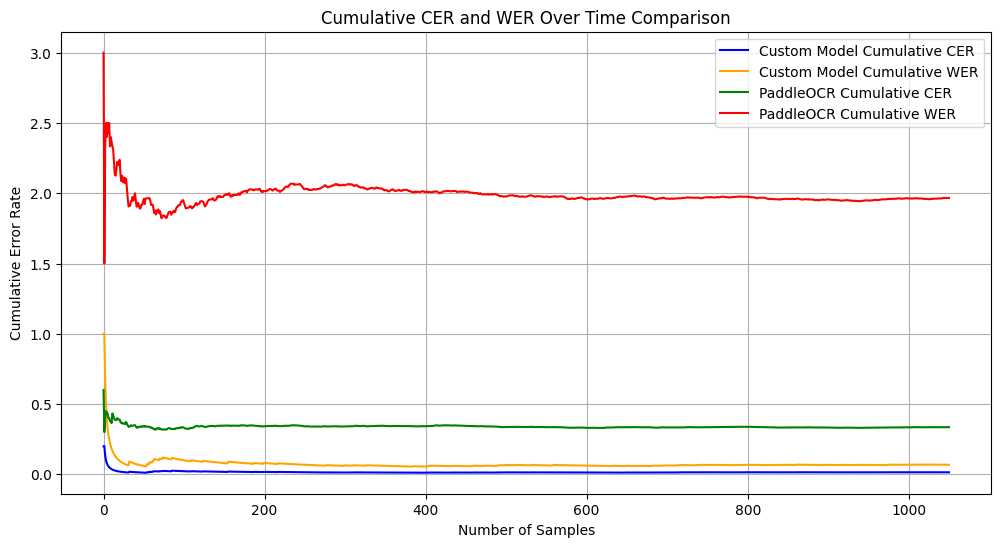

In [53]:
# Cumulative CER and WER Over Time for both models
cumulative_cer_model = [sum(cer_scores_model[:i + 1]) / (i + 1) for i in range(len(cer_scores_model))]
cumulative_wer_model = [sum(wer_scores_model[:i + 1]) / (i + 1) for i in range(len(wer_scores_model))]
cumulative_cer_paddle = [sum(cer_scores_paddle[:i + 1]) / (i + 1) for i in range(len(cer_scores_paddle))]
cumulative_wer_paddle = [sum(wer_scores_paddle[:i + 1]) / (i + 1) for i in range(len(wer_scores_paddle))]


plt.figure(figsize=(12, 6))
plt.plot(cumulative_cer_model, label='Custom Model Cumulative CER', color='blue')
plt.plot(cumulative_wer_model, label='Custom Model Cumulative WER', color='orange')
plt.plot(cumulative_cer_paddle, label='PaddleOCR Cumulative CER', color='green')
plt.plot(cumulative_wer_paddle, label='PaddleOCR Cumulative WER', color='red')
plt.title('Cumulative CER and WER Over Time Comparison')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Error Rate')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# Print final benchmark results
print(f"\nCustom Model - Accuracy: {accuracy_model * 100:.2f}%")
print(f"Custom Model - Average CER: {avg_cer_model}")
print(f"Custom Model - Average WER: {avg_wer_model}")
print(f"PaddleOCR - Accuracy: {accuracy_paddle * 100:.2f}%")
print(f"PaddleOCR - Average CER: {avg_cer_paddle}")
print(f"PaddleOCR - Average WER: {avg_wer_paddle}")

print("\nCustom Model - Most common letter errors:")
for letter, count in error_counter_model.most_common():
    print(f"Letter '{letter}' was mispredicted {count} times")


Custom Model - Accuracy: 93.43%
Custom Model - Average CER: 0.014081826831588947
Custom Model - Average WER: 0.0675547098001903
PaddleOCR - Accuracy: 14.75%
PaddleOCR - Average CER: 0.33549000951474595
PaddleOCR - Average WER: 1.9666983824928639

Custom Model - Most common letter errors:
Letter '0' was mispredicted 8 times
Letter 'I' was mispredicted 8 times
Letter 'J' was mispredicted 6 times
Letter 'O' was mispredicted 6 times
Letter '1' was mispredicted 5 times
Letter 'D' was mispredicted 5 times
Letter 'E' was mispredicted 4 times
Letter 'K' was mispredicted 3 times
Letter '6' was mispredicted 3 times
Letter 'A' was mispredicted 3 times
Letter 'C' was mispredicted 3 times
Letter 'L' was mispredicted 3 times
Letter 'T' was mispredicted 2 times
Letter 'U' was mispredicted 2 times
Letter '9' was mispredicted 2 times
Letter '8' was mispredicted 2 times
Letter 'F' was mispredicted 2 times
Letter 'V' was mispredicted 2 times
Letter '7' was mispredicted 1 times
Letter 'G' was mispredicte